In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

## 3-dimension Measurement Model

In [2]:
def polyfit2d(x, y, z, kx=3, ky=3, order=None):
    """
    Two dimensional polynomial fitting by least squares.
    Fits the functional form f(x,y) = z.

    Notes
    -----
    Resultant fit can be plotted with:
    np.polynomial.polynomial.polygrid2d(x, y, soln.reshape((kx+1, ky+1)))

    Parameters
    ----------
    x, y: array-like, 1d
        x and y coordinates.
    z: np.ndarray, 2d
        Surface to fit.
    kx, ky: int, default is 3
        Polynomial order in x and y, respectively.
    order: int or None, default is None
        If None, all coefficients up to maxiumum kx, ky, ie. up to and including x^kx*y^ky, are considered.
        If int, coefficients up to a maximum of kx+ky <= order are considered.

    Returns
    -------
    Return paramters from np.linalg.lstsq.

    soln: np.ndarray
        Array of polynomial coefficients.
    residuals: np.ndarray
    rank: int
    s: np.ndarray

    """

    # grid coords
    x, y = np.meshgrid(x, y)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((kx + 1, ky + 1))

    # solve array
    a = np.zeros((coeffs.size, x.size))

    # for each coefficient produce array x^i, y^j
    for index, (i, j) in enumerate(np.ndindex(coeffs.shape)):
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = coeffs[i, j] * x**i * y**j
        a[index] = arr.ravel()

    # do leastsq fitting and return leastsq result
    print(a.T.shape, np.ravel(z).shape)
    return np.linalg.lstsq(a.T, np.ravel(z), rcond=None)

In [3]:
import pandas as pd

dataframe = pd.read_excel("0-CalibrationData/30031142/FullRangeData_y.xlsx", sheet_name="FormatedWholeRang_ManuallyFixed")

z = np.array(dataframe)[:, 2]

x_len = 21
y_len = 10

x = np.linspace(0, 100, x_len)
y = np.linspace(130, 180, y_len)

# previously : kx - 4, ky - 4 for all bivariate polynoimial model
coeff, r, rank, s = polyfit2d(x, y, z, kx=3, ky=3)

(210, 16) (210,)


In [4]:
from sklearn.metrics import r2_score

print("Fitted results on Y-axis of magentic flux measurement: ")

fitted_surf = np.polynomial.polynomial.polygrid2d(x, y, coeff.reshape((4, 4)))

rms_y = np.sqrt(np.mean((z.reshape(y_len, x_len).T - fitted_surf) ** 2))
print("RMS residual =", rms_y)
score_y = r2_score(z.reshape(y_len, x_len).T, fitted_surf)
print("R-squared value =", score_y)

Fitted results on Y-axis of magentic flux measurement: 
RMS residual = 462.9466217848052
R-squared value = 0.9927418219305728


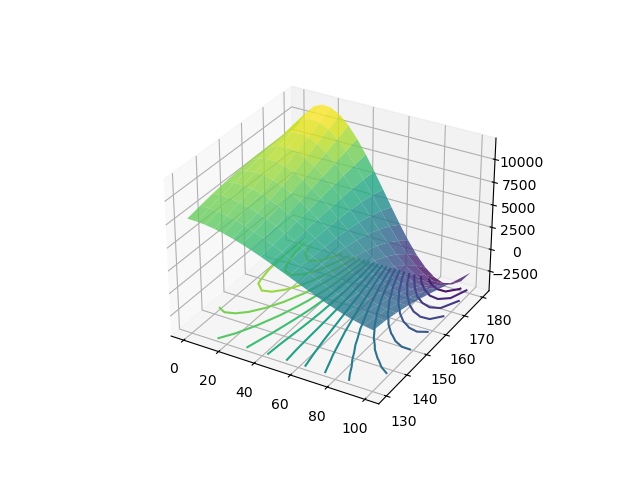

In [5]:
%matplotlib widget

X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

fitted_surf = fitted_surf

# Plot surface
surf = ax.plot_surface(X, Y, fitted_surf.T, cmap="viridis", alpha=0.8)

# Plot contour lines on the surface
num_levels = 20
contour_levels = np.linspace(np.min(fitted_surf), np.max(fitted_surf), num_levels)
contour_surf = ax.contour(X, Y, fitted_surf.T, levels=contour_levels, offset=np.min(fitted_surf), cmap='viridis')

plt.show()

## Parametricalize the implicit function

In [6]:
import sympy as sp

In [11]:
def FormEquation(coeff):

    # Define the symbolic variables
    x, y, z = sp.symbols('x y z', positive=True)

    # Initialize the polynomial expression and coefficient matrix
    polynomial = 0
    coeff_matrix = coeff.reshape((4, 4))

    # Add constraints to reduce solutions on y
    # constraint1 :

    # Iterate over each element in the matrix to construct the polynomial expression
    for i in range(coeff_matrix.shape[0]):  
        for j in range(coeff_matrix.shape[1]): 
            polynomial += coeff_matrix[i, j] * (x**j) * (y**i)

    equation = sp.Eq(z, polynomial)

    y_solutions = sp.solveset(equation, y, domain=sp.S.Reals)    
    print("Solutions for y in terms of x and z:", y_solutions)
    return y_solutions

In [12]:
FormEquation(coeff)

Solutions for y in terms of x and z: Intersection({-0.00377686723453304*(7789.22148770409*(-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**2/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 - 3*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))/(sqrt(-((-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**2/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 - 0.00038514760489681*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**3 + (-1.62043243317031e-5*(-4.01178475646262e-5*x**3 + 0.0134277640955505*x**2 - 1.51143031829683*x + 56.0941123551036)*(0.000866299480777101*x**3 - 

Intersection({-0.00377686723453304*(7789.22148770409*(-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**2/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 - 3*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))/(sqrt(-((-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**2/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 - 0.00038514760489681*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**3 + (-1.62043243317031e-5*(-4.01178475646262e-5*x**3 + 0.0134277640955505*x**2 - 1.51143031829683*x + 56.0941123551036)*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.416755284

In [13]:
x, y, z, t = sp.symbols('x y z t')

In [15]:
from sympy import sqrt

expr = -0.00377686723453304*(7789.22148770409*(-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**2/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 - 3*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))/(sqrt(-((-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**2/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 - 0.00038514760489681*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**3 + (-1.62043243317031e-5*(-4.01178475646262e-5*x**3 + 0.0134277640955505*x**2 - 1.51143031829683*x + 56.0941123551036)*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 + (-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**3/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**3 + 1.96377934868141e-5*(-0.00470079635785575*x**3 + 1.2181847239872*x**2 - 18.249601064668*x - 1.0*z - 0.316722556202559)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**2) - 1.62043243317031e-5*(-4.01178475646262e-5*x**3 + 0.0134277640955505*x**2 - 1.51143031829683*x + 56.0941123551036)*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 + (-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**3/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**3 + 1.96377934868141e-5*(-0.00470079635785575*x**3 + 1.2181847239872*x**2 - 18.249601064668*x - 1.0*z - 0.316722556202559)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**(1/3) - (-4.01178475646262e-5*x**3 + 0.0134277640955505*x**2 - 1.51143031829683*x + 56.0941123551036)/(3*(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618)) - 29.4188554194303*(sqrt(-((-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**2/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 - 0.00038514760489681*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**3 + (-1.62043243317031e-5*(-4.01178475646262e-5*x**3 + 0.0134277640955505*x**2 - 1.51143031829683*x + 56.0941123551036)*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 + (-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**3/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**3 + 1.96377934868141e-5*(-0.00470079635785575*x**3 + 1.2181847239872*x**2 - 18.249601064668*x - 1.0*z - 0.316722556202559)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**2) - 1.62043243317031e-5*(-4.01178475646262e-5*x**3 + 0.0134277640955505*x**2 - 1.51143031829683*x + 56.0941123551036)*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 + (-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**3/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**3 + 1.96377934868141e-5*(-0.00470079635785575*x**3 + 1.2181847239872*x**2 - 18.249601064668*x - 1.0*z - 0.316722556202559)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**(1/3), -0.00377686723453304*(7789.22148770409*(-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**2/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 - 3*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))/((-1/2 - sqrt(3)*I/2)*(sqrt(-((-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**2/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 - 0.00038514760489681*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**3 + (-1.62043243317031e-5*(-4.01178475646262e-5*x**3 + 0.0134277640955505*x**2 - 1.51143031829683*x + 56.0941123551036)*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 + (-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**3/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**3 + 1.96377934868141e-5*(-0.00470079635785575*x**3 + 1.2181847239872*x**2 - 18.249601064668*x - 1.0*z - 0.316722556202559)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**2) - 1.62043243317031e-5*(-4.01178475646262e-5*x**3 + 0.0134277640955505*x**2 - 1.51143031829683*x + 56.0941123551036)*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 + (-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**3/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**3 + 1.96377934868141e-5*(-0.00470079635785575*x**3 + 1.2181847239872*x**2 - 18.249601064668*x - 1.0*z - 0.316722556202559)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**(1/3)) - (-4.01178475646262e-5*x**3 + 0.0134277640955505*x**2 - 1.51143031829683*x + 56.0941123551036)/(3*(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618)) - 29.4188554194303*(-1/2 - sqrt(3)*I/2)*(sqrt(-((-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**2/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 - 0.00038514760489681*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**3 + (-1.62043243317031e-5*(-4.01178475646262e-5*x**3 + 0.0134277640955505*x**2 - 1.51143031829683*x + 56.0941123551036)*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 + (-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**3/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**3 + 1.96377934868141e-5*(-0.00470079635785575*x**3 + 1.2181847239872*x**2 - 18.249601064668*x - 1.0*z - 0.316722556202559)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**2) - 1.62043243317031e-5*(-4.01178475646262e-5*x**3 + 0.0134277640955505*x**2 - 1.51143031829683*x + 56.0941123551036)*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 + (-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**3/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**3 + 1.96377934868141e-5*(-0.00470079635785575*x**3 + 1.2181847239872*x**2 - 18.249601064668*x - 1.0*z - 0.316722556202559)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**(1/3), -0.00377686723453304*(7789.22148770409*(-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**2/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 - 3*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))/((-1/2 + sqrt(3)*I/2)*(sqrt(-((-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**2/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 - 0.00038514760489681*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**3 + (-1.62043243317031e-5*(-4.01178475646262e-5*x**3 + 0.0134277640955505*x**2 - 1.51143031829683*x + 56.0941123551036)*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 + (-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**3/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**3 + 1.96377934868141e-5*(-0.00470079635785575*x**3 + 1.2181847239872*x**2 - 18.249601064668*x - 1.0*z - 0.316722556202559)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**2) - 1.62043243317031e-5*(-4.01178475646262e-5*x**3 + 0.0134277640955505*x**2 - 1.51143031829683*x + 56.0941123551036)*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 + (-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**3/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**3 + 1.96377934868141e-5*(-0.00470079635785575*x**3 + 1.2181847239872*x**2 - 18.249601064668*x - 1.0*z - 0.316722556202559)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**(1/3)) - (-4.01178475646262e-5*x**3 + 0.0134277640955505*x**2 - 1.51143031829683*x + 56.0941123551036)/(3*(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618)) - 29.4188554194303*(-1/2 + sqrt(3)*I/2)*(sqrt(-((-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**2/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 - 0.00038514760489681*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**3 + (-1.62043243317031e-5*(-4.01178475646262e-5*x**3 + 0.0134277640955505*x**2 - 1.51143031829683*x + 56.0941123551036)*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 + (-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**3/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**3 + 1.96377934868141e-5*(-0.00470079635785575*x**3 + 1.2181847239872*x**2 - 18.249601064668*x - 1.0*z - 0.316722556202559)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**2) - 1.62043243317031e-5*(-4.01178475646262e-5*x**3 + 0.0134277640955505*x**2 - 1.51143031829683*x + 56.0941123551036)*(0.000866299480777101*x**3 - 0.223303284799815*x**2 + 14.4167552841376*x + 1.92837275763761)/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**2 + (-7.15188205682984e-7*x**3 + 0.000239379206333565*x**2 - 0.0269445447095896*x + 1)**3/(5.33641608750536e-7*x**3 - 0.000193651736243438*x**2 + 0.0239634520994631*x - 1)**3 + 1.96377934868141e-5*(-0.00470079635785575*x**3 + 1.2181847239872*x**2 - 18.249601064668*x - 1.0*z - 0.316722556202559)/(3.39171957710271e-7*x**3 - 0.000123081179238376*x**2 + 0.0152306919640345*x - 0.635580045012618))**(1/3)
new_expr = expr.subs(x, t)
print(new_expr)

NameError: name 'I' is not defined

## Transform into 2-dim function

In [23]:
def x(t, z):
    return t

def y(t, z):
    return (-14.4182642935803*(2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**2/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 - 0.00770627510001905*(1.55977554585123e+18*t**3 - 4.69380623116593e+20*t**2 + 3.54171294208959e+22*t - 2.15326601515576e+22)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))/((-((2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**2/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (833668963604997.0*t**3 - 2.50874594521435e+17*t**2 + 1.89297502815181e+19*t - 1.15087779904967e+19)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**3 + ((3.27834440338354e-30*t**3 - 9.86546649576549e-28*t**2 + 7.4439907927611e-26*t - 4.52574577704988e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**3/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + (23092554781028.3*t**3 - 1.72704270358346e+16*t**2 + 1.20932284177323e+19*t - 1.6681344756015e+17*z + 2.95775616041783e+17)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**2)**0.5 - (-3.27834440338354e-30*t**3 + 9.86546649576549e-28*t**2 - 7.4439907927611e-26*t + 4.52574577704988e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**3/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + (23092554781028.3*t**3 - 1.72704270358346e+16*t**2 + 1.20932284177323e+19*t - 1.6681344756015e+17*z + 2.95775616041783e+17)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**0.333333333333333 - 14.4182642935802*((-((2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**2/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (833668963604997.0*t**3 - 2.50874594521435e+17*t**2 + 1.89297502815181e+19*t - 1.15087779904967e+19)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**3 + ((3.27834440338354e-30*t**3 - 9.86546649576549e-28*t**2 + 7.4439907927611e-26*t - 4.52574577704988e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**3/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + (23092554781028.3*t**3 - 1.72704270358346e+16*t**2 + 1.20932284177323e+19*t - 1.6681344756015e+17*z + 2.95775616041783e+17)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**2)**0.5 - (-3.27834440338354e-30*t**3 + 9.86546649576549e-28*t**2 - 7.4439907927611e-26*t + 4.52574577704988e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**3/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + (23092554781028.3*t**3 - 1.72704270358346e+16*t**2 + 1.20932284177323e+19*t - 1.6681344756015e+17*z + 2.95775616041783e+17)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**0.333333333333333 - (1.25771726355482e+15*t**3 + 1.72930503708072e+18*t**2 - 5.75243810341239e+20*t + 4.28164860624403e+22)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21)

In [32]:
def dx_dt(t, z):
    return 1

def dy_dt(t, z):
    return (-14.4182642935803*(2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**2/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 - (1.2020059450612e+16*t**3 - 3.61717620835483e+18*t**2 + 2.72934142570402e+20*t - 1.65936602763121e+20)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))*(-0.333333333333333*(-0.5*((2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**2/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (833668963604997.0*t**3 - 2.50874594521435e+17*t**2 + 1.89297502815181e+19*t - 1.15087779904967e+19)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**2*(3.4019284476393e-43*(-747787277615943.0*t**2 + 4.41123658747738e+17*t - 4.72034304659153e+19)*(833668963604997.0*t**3 - 2.50874594521435e+17*t**2 + 1.89297502815181e+19*t - 1.15087779904967e+19)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + 3*(-5.03628186036573e-7*t**2 + 0.000297092922978345*t - 0.0317910972436496)*(2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**2/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + 3*(1.76247615704006e-7*t**2 + 0.000161555064052555*t - 0.0268702017957452)*(2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + 3*(2.50100689081499e+15*t**2 - 5.0174918904287e+17*t + 1.89297502815181e+19)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21)) + 0.5*((3.27834440338354e-30*t**3 - 9.86546649576549e-28*t**2 + 7.4439907927611e-26*t - 4.52574577704988e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**3/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + (23092554781028.3*t**3 - 1.72704270358346e+16*t**2 + 1.20932284177323e+19*t - 1.6681344756015e+17*z + 2.95775616041783e+17)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))*(2.2679522984262e-43*(-747787277615943.0*t**2 + 4.41123658747738e+17*t - 4.72034304659153e+19)*(23092554781028.3*t**3 - 1.72704270358346e+16*t**2 + 1.20932284177323e+19*t - 1.6681344756015e+17*z + 2.95775616041783e+17)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + 2*(-7.5544227905486e-7*t**2 + 0.000445639384467517*t - 0.0476866458654744)*(2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**3/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**4 + 2*(-5.03628186036573e-7*t**2 + 0.000297092922978345*t - 0.0317910972436496)*(3.27834440338354e-30*t**3 - 9.86546649576549e-28*t**2 + 7.4439907927611e-26*t - 4.52574577704988e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + 2*(9.83503321015062e-30*t**2 - 1.9730932991531e-27*t + 7.4439907927611e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + 2*(2.6437142355601e-7*t**2 + 0.000242332596078833*t - 0.0403053026936178)*(2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**2/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + 2*(69277664343084.9*t**2 - 3.45408540716692e+16*t + 1.20932284177323e+19)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21) + 2*(1.13194553719934e+16*t**2 + 1.03758302224843e+19*t - 1.72573143102372e+21)*(3.27834440338354e-30*t**3 - 9.86546649576549e-28*t**2 + 7.4439907927611e-26*t - 4.52574577704988e-26)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2))/(-((2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**2/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (833668963604997.0*t**3 - 2.50874594521435e+17*t**2 + 1.89297502815181e+19*t - 1.15087779904967e+19)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**3 + ((3.27834440338354e-30*t**3 - 9.86546649576549e-28*t**2 + 7.4439907927611e-26*t - 4.52574577704988e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**3/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + (23092554781028.3*t**3 - 1.72704270358346e+16*t**2 + 1.20932284177323e+19*t - 1.6681344756015e+17*z + 2.95775616041783e+17)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**2)**0.5 - 3.779920497377e-44*(-747787277615943.0*t**2 + 4.41123658747738e+17*t - 4.72034304659153e+19)*(23092554781028.3*t**3 - 1.72704270358346e+16*t**2 + 1.20932284177323e+19*t - 1.6681344756015e+17*z + 2.95775616041783e+17)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 - 0.333333333333333*(-7.5544227905486e-7*t**2 + 0.000445639384467517*t - 0.0476866458654744)*(2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**3/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**4 + 0.333333333333333*(-5.03628186036573e-7*t**2 + 0.000297092922978345*t - 0.0317910972436496)*(-3.27834440338354e-30*t**3 + 9.86546649576549e-28*t**2 - 7.4439907927611e-26*t + 4.52574577704988e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + 0.333333333333333*(-9.83503321015062e-30*t**2 + 1.9730932991531e-27*t - 7.4439907927611e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 - 0.333333333333333*(2.6437142355601e-7*t**2 + 0.000242332596078833*t - 0.0403053026936178)*(2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**2/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 - 0.333333333333333*(69277664343084.9*t**2 - 3.45408540716692e+16*t + 1.20932284177323e+19)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21) + 0.333333333333333*(1.13194553719934e+16*t**2 + 1.03758302224843e+19*t - 1.72573143102372e+21)*(-3.27834440338354e-30*t**3 + 9.86546649576549e-28*t**2 - 7.4439907927611e-26*t + 4.52574577704988e-26)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2)/((-((2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**2/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (833668963604997.0*t**3 - 2.50874594521435e+17*t**2 + 1.89297502815181e+19*t - 1.15087779904967e+19)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**3 + ((3.27834440338354e-30*t**3 - 9.86546649576549e-28*t**2 + 7.4439907927611e-26*t - 4.52574577704988e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**3/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + (23092554781028.3*t**3 - 1.72704270358346e+16*t**2 + 1.20932284177323e+19*t - 1.6681344756015e+17*z + 2.95775616041783e+17)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**2)**0.5 - (-3.27834440338354e-30*t**3 + 9.86546649576549e-28*t**2 - 7.4439907927611e-26*t + 4.52574577704988e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**3/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + (23092554781028.3*t**3 - 1.72704270358346e+16*t**2 + 1.20932284177323e+19*t - 1.6681344756015e+17*z + 2.95775616041783e+17)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**1.33333333333333 - 1.1339761492131e-43*(-747787277615943.0*t**2 + 4.41123658747738e+17*t - 4.72034304659153e+19)*(1.25771726355482e+15*t**3 + 1.72930503708072e+18*t**2 - 5.75243810341239e+20*t + 4.28164860624403e+22)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 - (3.77315179066446e+15*t**2 + 3.45861007416144e+18*t - 5.75243810341239e+20)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21) + (-1.1339761492131e-43*(-747787277615943.0*t**2 + 4.41123658747738e+17*t - 4.72034304659153e+19)*(1.2020059450612e+16*t**3 - 3.61717620835483e+18*t**2 + 2.72934142570402e+20*t - 1.65936602763121e+20)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 - 14.4182642935803*(-5.03628186036573e-7*t**2 + 0.000297092922978345*t - 0.0317910972436496)*(2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**2/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 - 14.4182642935803*(1.76247615704006e-7*t**2 + 0.000161555064052555*t - 0.0268702017957452)*(2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 - (3.60601783518359e+16*t**2 - 7.23435241670965e+18*t + 2.72934142570402e+20)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))/((-((2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**2/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (833668963604997.0*t**3 - 2.50874594521435e+17*t**2 + 1.89297502815181e+19*t - 1.15087779904967e+19)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**3 + ((3.27834440338354e-30*t**3 - 9.86546649576549e-28*t**2 + 7.4439907927611e-26*t - 4.52574577704988e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**3/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + (23092554781028.3*t**3 - 1.72704270358346e+16*t**2 + 1.20932284177323e+19*t - 1.6681344756015e+17*z + 2.95775616041783e+17)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**2)**0.5 - (-3.27834440338354e-30*t**3 + 9.86546649576549e-28*t**2 - 7.4439907927611e-26*t + 4.52574577704988e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**3/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + (23092554781028.3*t**3 - 1.72704270358346e+16*t**2 + 1.20932284177323e+19*t - 1.6681344756015e+17*z + 2.95775616041783e+17)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**0.333333333333333 - 14.4182642935802*(0.333333333333333*(-0.5*((2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**2/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (833668963604997.0*t**3 - 2.50874594521435e+17*t**2 + 1.89297502815181e+19*t - 1.15087779904967e+19)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**2*(3.4019284476393e-43*(-747787277615943.0*t**2 + 4.41123658747738e+17*t - 4.72034304659153e+19)*(833668963604997.0*t**3 - 2.50874594521435e+17*t**2 + 1.89297502815181e+19*t - 1.15087779904967e+19)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + 3*(-5.03628186036573e-7*t**2 + 0.000297092922978345*t - 0.0317910972436496)*(2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**2/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + 3*(1.76247615704006e-7*t**2 + 0.000161555064052555*t - 0.0268702017957452)*(2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + 3*(2.50100689081499e+15*t**2 - 5.0174918904287e+17*t + 1.89297502815181e+19)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21)) + 0.5*((3.27834440338354e-30*t**3 - 9.86546649576549e-28*t**2 + 7.4439907927611e-26*t - 4.52574577704988e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**3/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + (23092554781028.3*t**3 - 1.72704270358346e+16*t**2 + 1.20932284177323e+19*t - 1.6681344756015e+17*z + 2.95775616041783e+17)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))*(2.2679522984262e-43*(-747787277615943.0*t**2 + 4.41123658747738e+17*t - 4.72034304659153e+19)*(23092554781028.3*t**3 - 1.72704270358346e+16*t**2 + 1.20932284177323e+19*t - 1.6681344756015e+17*z + 2.95775616041783e+17)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + 2*(-7.5544227905486e-7*t**2 + 0.000445639384467517*t - 0.0476866458654744)*(2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**3/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**4 + 2*(-5.03628186036573e-7*t**2 + 0.000297092922978345*t - 0.0317910972436496)*(3.27834440338354e-30*t**3 - 9.86546649576549e-28*t**2 + 7.4439907927611e-26*t - 4.52574577704988e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + 2*(9.83503321015062e-30*t**2 - 1.9730932991531e-27*t + 7.4439907927611e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + 2*(2.6437142355601e-7*t**2 + 0.000242332596078833*t - 0.0403053026936178)*(2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**2/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + 2*(69277664343084.9*t**2 - 3.45408540716692e+16*t + 1.20932284177323e+19)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21) + 2*(1.13194553719934e+16*t**2 + 1.03758302224843e+19*t - 1.72573143102372e+21)*(3.27834440338354e-30*t**3 - 9.86546649576549e-28*t**2 + 7.4439907927611e-26*t - 4.52574577704988e-26)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2))/(-((2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**2/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (833668963604997.0*t**3 - 2.50874594521435e+17*t**2 + 1.89297502815181e+19*t - 1.15087779904967e+19)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**3 + ((3.27834440338354e-30*t**3 - 9.86546649576549e-28*t**2 + 7.4439907927611e-26*t - 4.52574577704988e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**3/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + (23092554781028.3*t**3 - 1.72704270358346e+16*t**2 + 1.20932284177323e+19*t - 1.6681344756015e+17*z + 2.95775616041783e+17)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**2)**0.5 + 3.779920497377e-44*(-747787277615943.0*t**2 + 4.41123658747738e+17*t - 4.72034304659153e+19)*(23092554781028.3*t**3 - 1.72704270358346e+16*t**2 + 1.20932284177323e+19*t - 1.6681344756015e+17*z + 2.95775616041783e+17)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + 0.333333333333333*(-7.5544227905486e-7*t**2 + 0.000445639384467517*t - 0.0476866458654744)*(2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**3/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**4 - 0.333333333333333*(-5.03628186036573e-7*t**2 + 0.000297092922978345*t - 0.0317910972436496)*(-3.27834440338354e-30*t**3 + 9.86546649576549e-28*t**2 - 7.4439907927611e-26*t + 4.52574577704988e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 - 0.333333333333333*(-9.83503321015062e-30*t**2 + 1.9730932991531e-27*t - 7.4439907927611e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + 0.333333333333333*(2.6437142355601e-7*t**2 + 0.000242332596078833*t - 0.0403053026936178)*(2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**2/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + 0.333333333333333*(69277664343084.9*t**2 - 3.45408540716692e+16*t + 1.20932284177323e+19)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21) - 0.333333333333333*(1.13194553719934e+16*t**2 + 1.03758302224843e+19*t - 1.72573143102372e+21)*(-3.27834440338354e-30*t**3 + 9.86546649576549e-28*t**2 - 7.4439907927611e-26*t + 4.52574577704988e-26)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2)/((-((2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**2/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (833668963604997.0*t**3 - 2.50874594521435e+17*t**2 + 1.89297502815181e+19*t - 1.15087779904967e+19)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**3 + ((3.27834440338354e-30*t**3 - 9.86546649576549e-28*t**2 + 7.4439907927611e-26*t - 4.52574577704988e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**3/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + (23092554781028.3*t**3 - 1.72704270358346e+16*t**2 + 1.20932284177323e+19*t - 1.6681344756015e+17*z + 2.95775616041783e+17)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**2)**0.5 - (-3.27834440338354e-30*t**3 + 9.86546649576549e-28*t**2 - 7.4439907927611e-26*t + 4.52574577704988e-26)*(3.77315179066447e+15*t**3 + 5.18791511124216e+18*t**2 - 1.72573143102372e+21*t + 1.28449458187321e+23)/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**2 + (2.93746026173344e-8*t**3 + 4.03887660131388e-5*t**2 - 0.0134351008978726*t + 1)**3/(8.39380310060955e-8*t**3 - 7.42732307445862e-5*t**2 + 0.0158955486218248*t - 1)**3 + (23092554781028.3*t**3 - 1.72704270358346e+16*t**2 + 1.20932284177323e+19*t - 1.6681344756015e+17*z + 2.95775616041783e+17)/(249262425871981.0*t**3 - 2.20561829373869e+17*t**2 + 4.72034304659153e+19*t - 2.96960058371967e+21))**0.666666666666667

In [ ]:
from scipy.integrate import quad
from scipy.optimize import fsolve

def arc_length(t, t0, z):
    
    # " typically occurs when you attempt to compute a derivative with respect to a numerical value instead of a symbolic variable using SymPy "
    
    # integral, _ = quad(lambda u: np.sqrt(dx_dt(u)**2 + dy_dt(u)**2), t0, t)
    
    integral, _ = quad(lambda u: np.sqrt(dx_dt(u, z)**2 + dy_dt(u, z)**2), t0, t)
    
    return integral

In [ ]:
L = 70

def equation(t, z):
    return arc_length(t, 0, z) - L